The downstream study based on sklearn framework.
====================
Study of the seed selection
-----------------------------

At first I want to look at the input data and then prepare baseline for further studies. 
I would like to use fisher and BDT as a baseline clasifiers. And then more sophisticated models (deep NN) will be used. 

In [217]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

As a very first step I need to grab training data form the NTpule. 
--------------------------

In [218]:
root_file = ROOT.TFile("datasets/Brunel_preselection_5kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [219]:
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.213708,2543.471925,1187.267858,25.0,0.0,12.0,-1263.157617,-517.249191,-0.524220,-0.061572
1,1.346112,2781.485771,1204.396954,25.0,0.0,12.0,1264.522435,-99.363473,0.480288,-0.009081
2,1.627632,4769.446536,1708.511389,25.0,0.0,12.0,-1521.093160,-196.064807,-0.382802,-0.025975
3,1.789231,5202.918132,1823.936187,25.0,0.0,12.0,-1563.145597,-483.850246,-0.369674,-0.058753
4,1.269238,2300.960611,1252.585447,24.0,0.0,12.0,-1641.727752,-411.084316,-0.646627,-0.054980


Print the features
-------------------------

In [220]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,337291.000000,3.372910e+05,3.372910e+05,337291.000000,337291.000000,337291.000000,337291.000000,337291.000000,337291.000000,337291.000000
mean,1.517037,2.211789e+04,2.196243e+03,18.722554,3.151878,11.539300,15.402574,-1.379834,0.010450,-0.000132
std,0.829149,7.881846e+05,8.590252e+04,4.734461,5.052006,0.809568,706.761944,477.788969,0.291848,0.061804
min,0.002426,1.197563e+03,1.762072e+00,8.000000,0.000000,8.000000,-2455.114846,-2126.348264,-1.118789,-0.406831
25%,0.909067,3.532194e+03,9.944996e+02,13.000000,0.000000,11.000000,-372.118440,-187.880756,-0.150078,-0.026654
50%,1.346665,6.760680e+03,1.155453e+03,20.000000,0.000000,12.000000,13.148397,0.066661,0.011061,0.000014
75%,1.963339,1.520037e+04,1.399159e+03,22.000000,8.000000,12.000000,411.256885,185.720268,0.174055,0.026627
max,8.792842,3.601153e+08,3.166954e+07,32.000000,20.000000,12.000000,2421.930280,2141.645310,1.132967,0.348517


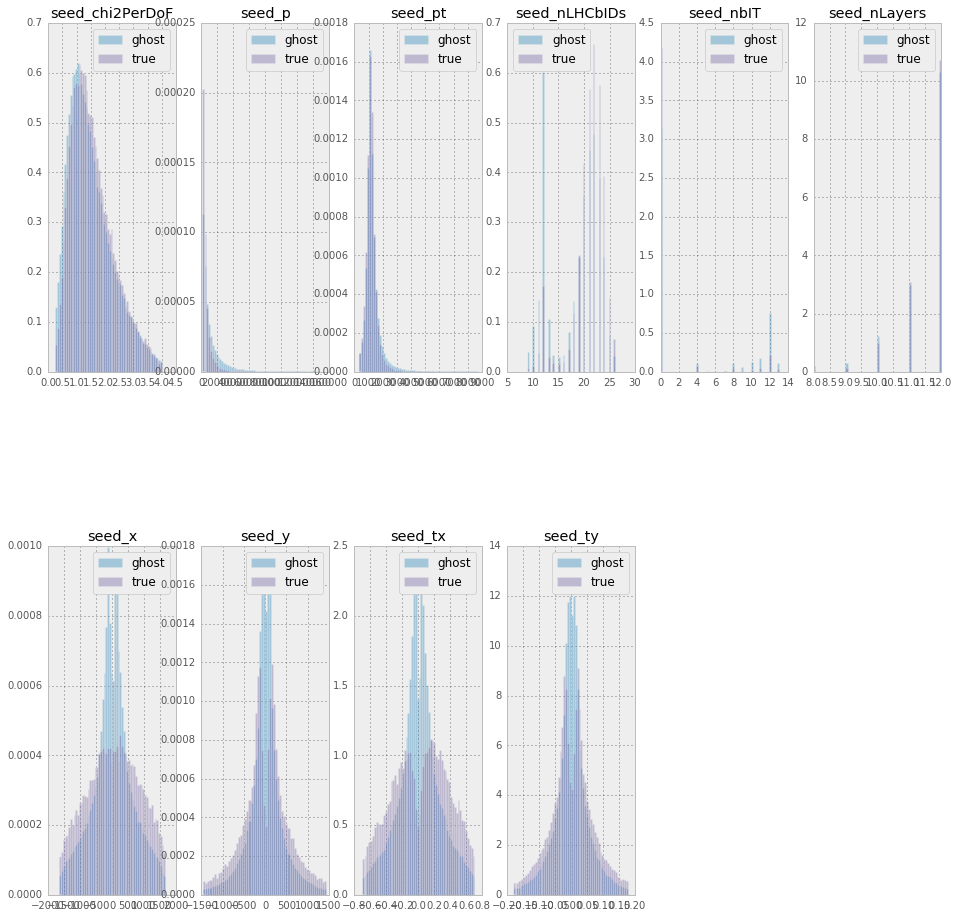

In [221]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
fig = plt.figure(figsize=(16,  25))
for n, feature in enumerate(features):
    # add sub plot on our figure
    ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    ax.hist(data.ix[data.is_true_seed.values == 0, feature].values, range=(min_value, max_value), 
             label='ghost', **hist_params)
    ax.hist(data.ix[data.is_true_seed.values == 1, feature].values, range=(min_value, max_value), 
             label='true', **hist_params)
    ax.legend(loc='best')

    ax.set_title(feature)

In [222]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)


Training of the baselines's clasifiers
=======================

Split data into test and validation sets
----------------------

In [223]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.9 )

At first try kNN. 
---------------
As a k I choose arbitrary value equal to 6. This value can be tuned via grid search but it is pointless. 
I am not using any of the feature engenering. I just want to create very low level baseline.

In [229]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(trainX,trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [230]:
print "ROC AUC score"
roc_auc_score(testY, knn.predict_proba(testX)[:, 1])

0.68977973169083717

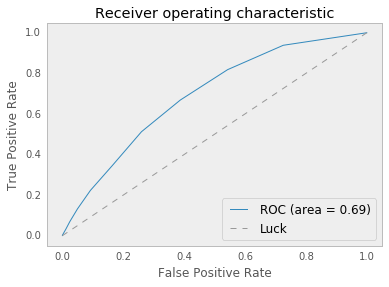

In [231]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testY, knn.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()